### This notebook trains a Neural Network model for sentiment analysis using USE embeddings

Import modules

In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import sparknlp
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
print("Spark NLP version", sparknlp.version())
print(f"Tensorflow version:{tf.__version__}\nKeras version:{keras.__version__}")

Spark NLP version 2.4.5
Tensorflow version:2.3.0
Keras version:2.4.0


<span>Writing the dataset file to parquet format.</span>
<code style="font-size:10px; background:none;">
spark = sparknlp.start()
df_spark = spark.read.csv('data/amazon_reviews_us_Electronics_v1_00.tsv', header='true', inferSchema='true', sep='\t')
df_spark.write.parquet("data/df.parquet") # Error if the file already exists.
</code>

#### Filtering dataset for training

In [3]:
df_pq = pq.read_table('data/df.parquet')
df_pandas = df_pq.to_pandas()
counts = df_pandas.groupby('product_id').count()
products_10_or_more_reviews = counts.index[counts.iloc[:,0] >= 10]
mask = df_pandas.product_id.map(lambda x: x in products_10_or_more_reviews).values
df_sentiment = df_pandas.loc[~mask,:] # Dataset that has fewer than 10 reviews are used for training sentiment
df_similarity = df_pandas.loc[mask, :]
# pd.to_pickle(df_sentiment, 'data/products_fewer_than_10_reviews.pkl')
# pd.to_pickle(df_similarity, 'data/products_10_or_more_reviews.pkl')
print(f"The number of unique products in the dataset = {df_pandas.product_parent.nunique()}")

The number of unique products in the dataset = 166244


#### Define the target for training

In [4]:
reviews = df_sentiment.loc[:,['review_body', 'star_rating']]
target = reviews.star_rating.map(lambda x: 1 if x == 5. else (x if pd.isnull(x) else 0)).values

#### Load Universal Sentence Encoder and convert the features into Tensor

In [5]:
embed = hub.load('use')
tensors = tf.convert_to_tensor(reviews["review_body"].apply(lambda x: str(x)).values)
# %time embeddings = embed(tensors) # <== Need to use GPU

<span>Convert to embeddings using chunks (using GPU)</span>
<code style="font-size:10px; background:none;">
chunksize = tensors.shape[0] // 10000
bounds = chunksize * np.arange(tensors.shape[0] // chunksize)
len(bounds)<br>
bounds_tuples = list()
for i, bound in enumerate(bounds):
  if i == tensors.shape[0] // chunksize - 1: break
  bounds_tuples.append((bounds[i], bounds[i+1]))
bounds_tuples.append((bounds_tuples[-1][1], tensors.shape[0]))<br>
rev = reviews['review_body'].map(lambda x: str(x)[:512])
with tf.device('/GPU:0'):
  print(f"{len(bounds_tuples)} chunks to embed.")
  embeddings = embed(tensors_from_series(rev, 0, bounds_tuples[0][1]))
  for i, bounds_tuple in enumerate(bounds_tuples[1:]):
    if i % 100 == 0: 
      print(i,end='  ')
    embeddings = tf.concat([embeddings, embed(tensors_from_series(rev, bounds_tuple[0], bounds_tuple[1]))], 0)
</code>

#### Loading the saved embeddings

In [6]:
embeddings = pd.read_pickle('embeddings.pkl')

#### Convert the target to one-hot-encoding which makes the shape = (dataset_size, 2) and then Train-test split 

In [7]:
embeddings_np = embeddings.numpy()
target = reviews.star_rating.map(lambda x: 1 if x == 5. else (x if pd.isnull(x) else 0)).values

X, y = embeddings_np[~np.isnan(target),:], target[~np.isnan(target)]

type_one_hot = OneHotEncoder(sparse=False).fit_transform(y.reshape(-1,1))
X_train, X_test, y_train, y_test = \
train_test_split(X, type_one_hot, test_size = .1, random_state = 100)# Same Random state can set different order in google colab 
print(f"Target imbalance ratio: {(sum(y) / len(y)):.2f}")
print(f"Training set and target shape: {X_train.shape, y_train.shape}")

Target imbalance ratio: 0.54
Training set and target shape: ((311806, 512), (311806, 2))


<span>Training ReLU-Dropout-ReLU-Dropout-Sigmoid DNN. Followed by this blog: </span>[Sentiment Analysis with TensorFlow 2 and Keras using Python](https://www.curiousily.com/posts/sentiment-analysis-with-tensorflow-2-and-keras-using-python/)
<code style="font-size:10px; background:none;">
model = keras.Sequential()
model.add(
  keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)
model.add(
  keras.layers.Dense(
    units=128,
    activation='relu'
  )
)
model.add(
  keras.layers.Dropout(rate=0.5)
)
model.add(keras.layers.Dense(2, activation='sigmoid'))
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)
with tf.device("/gpu:0"):
    history = model.fit(X_train,
                        y_train,
                        epochs=40,
                        batch_size=2**16,
                        validation_split=0.1,
                        verbose=0,
                        shuffle=True)
</code>

#### Example of running only 5 epochs

In [8]:
history.history # Printing

{'loss': [0.6841068267822266,
  0.6504842042922974,
  0.5999653339385986,
  0.5445443987846375,
  0.5041335821151733],
 'accuracy': [0.5603598952293396,
  0.6334111094474792,
  0.7285594940185547,
  0.7642013430595398,
  0.7776142358779907],
 'val_loss': [0.6623894572257996,
  0.6128974556922913,
  0.5521790981292725,
  0.503189206123352,
  0.4750252962112427],
 'val_accuracy': [0.5824701189994812,
  0.726917028427124,
  0.7688977122306824,
  0.7801225185394287,
  0.7875950336456299]}

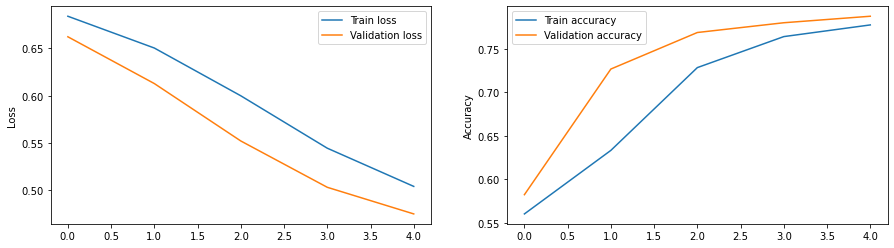

In [9]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].plot(history.epoch, history.history["loss"], label='Train loss')
ax[0].plot(history.epoch, history.history["val_loss"], label = 'Validation loss')
ax[0].legend()
ax[0].set_ylabel('Loss')
ax[1].plot(history.epoch, history.history["accuracy"], label='Train accuracy')
ax[1].plot(history.epoch, history.history["val_accuracy"], label = 'Validation accuracy')
ax[1].legend()
ax[1].set_ylabel('Accuracy');

#### Loading the trained model, train, test set

In [10]:
model = keras.models.load_model('model') # From google colab. 40 epochs 2**16 batchsize

In [11]:
X_train, X_test, y_train, y_test = pd.read_pickle('train_sentiment/X_train.pkl'), pd.read_pickle('train_sentiment/X_test.pkl'), pd.read_pickle('train_sentiment/y_train.pkl'), pd.read_pickle('train_sentiment/y_test.pkl')
X_train_txt, X_test_txt, y_train_txt, y_test_txt = pd.read_pickle('train_sentiment/X_train_txt.pkl'), pd.read_pickle('train_sentiment/X_test_txt.pkl'), pd.read_pickle('train_sentiment/y_train_txt.pkl'), pd.read_pickle('train_sentiment/y_test_txt.pkl')

In [12]:
model.evaluate(X_test, y_test)

1083/1083 [==============================] - 1s 665us/step - loss: 0.4166 - accuracy: 0.8221


[0.41658204793930054, 0.8221151232719421]

Model's sentiment predictions

In [13]:
i = 3
embed1 = embed([X_test_txt.iloc[i]])
print(X_test_txt.iloc[i])
model.predict(embed1)

Works great, sounds great, easy to use and the kids love it. The only thing I would add is a plug for the outlet. Batteries always seem to run down at the most inconvenient times.


array([[0.35643917, 0.6433982 ]], dtype=float32)

In [14]:
embed2 = embed(['Pleasure to my ear'])
model.predict(embed2)

array([[0.09055609, 0.9087105 ]], dtype=float32)